In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")

print("Path to dataset files:", path)

c:\Users\user\Downloads\Program_project_py\ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\xinwangcs\stressor-cause-of-mental-health-problem-dataset\versions\1


In [3]:
import pandas as pd
import numpy as np
import os
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
print("Files in dataset:", FILES)



Files in dataset: ['C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_test.json', 'C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_train.json']


In [4]:
import json

def load_data2dataframe(file):
    """Load JSON data from a file into a pandas DataFrame.

    Args:
        file (str): The path to the JSON file.

    Raises:
        ValueError: If no JSON files are found in the dataset directory.
        ValueError: If the specified JSON file does not exist.

    Returns:
        pd.DataFrame: A DataFrame containing the loaded data.
    """
    if not FILES:
        raise ValueError("No JSON files found in the dataset directory.")
    if not os.path.exists(file):
        raise ValueError(f"File '{file}' does not exist.")
    with open(file, encoding="utf-8") as f:
        data = json.load(f)
        if not isinstance(data, list):
            raise ValueError(f"Expected a list in JSON file, got {type(data)}")
        temp = []
        for item in data:
            #print(item)
            TEXT = item["text"]
            INTERVAL = item["interval"]
            try:
                STRESSOR_class = item["labels"][0][0]
                STRESSOR_WORD = item["labels"][0][4]
            except IndexError:
                STRESSOR_class = np.nan
                STRESSOR_WORD = np.nan
            temp.append((TEXT, STRESSOR_class, STRESSOR_WORD, INTERVAL))

    # Convert list of tuples to DataFrame with column names
    return pd.DataFrame(temp, columns=["text", "stressor_class", "stressor_word", "interval"])

# Ensure each element is a DataFrame before concatenation
dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

將"stressor_word"轉換為小寫
 ---

In [7]:
df["stressor_word"] = df["stressor_word"].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [8]:
df["stressor_word"].value_counts().sort_values(ascending=False)


stressor_word
work                        489
life                        290
job                          60
exam                         59
studying                     52
                           ... 
being loved                   1
scrolling through tiktok      1
surgery                       1
worker                        1
mice                          1
Name: count, Length: 1503, dtype: int64

Labels為分析對象，將其重新劃分分類至各主題，以去除類別數量懸殊問題
---

In [9]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

# 每筆 stressor_word 當作一篇文件（可分群）
docs = df['stressor_word'].astype(str).str.split()  # 處理複數詞如 "my mom"
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]


In [10]:
coherence_scores = []

for k in range(10,31):
    lda = LdaModel(corpus=corpus,
                   id2word=dictionary, 
                   num_topics=k, random_state=42, passes=10)
    
    coherence = CoherenceModel(
        model=lda, texts=docs, dictionary=dictionary, coherence='c_v'
    ).get_coherence()
    
    coherence_scores.append((k, coherence))
    print(f"Topic {k}: Coherence = {coherence:.4f}")


Topic 10: Coherence = 0.7069
Topic 11: Coherence = 0.7061
Topic 12: Coherence = 0.6985
Topic 13: Coherence = 0.7119
Topic 14: Coherence = 0.7141
Topic 15: Coherence = 0.6998
Topic 16: Coherence = 0.7051
Topic 17: Coherence = 0.6985
Topic 18: Coherence = 0.7155
Topic 19: Coherence = 0.7088
Topic 20: Coherence = 0.7057
Topic 21: Coherence = 0.6972
Topic 22: Coherence = 0.6906
Topic 23: Coherence = 0.6995
Topic 24: Coherence = 0.6935
Topic 25: Coherence = 0.6812
Topic 26: Coherence = 0.6765
Topic 27: Coherence = 0.6360
Topic 28: Coherence = 0.6418
Topic 29: Coherence = 0.6151
Topic 30: Coherence = 0.6157


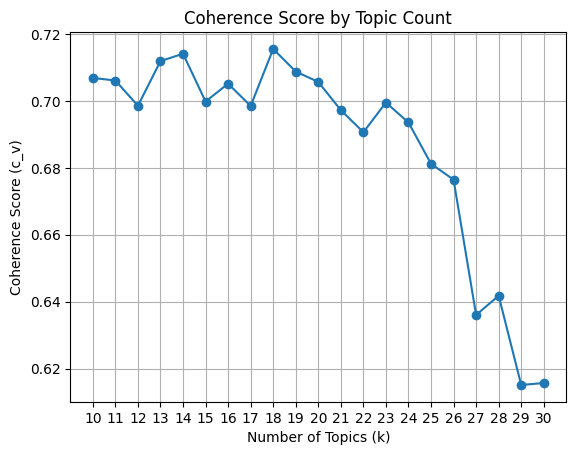

In [11]:
import matplotlib.pyplot as plt

x, y = zip(*coherence_scores)
plt.plot(x, y, marker='o')
plt.xticks(range(10, 31, 1))
plt.xlabel("Number of Topics (k)")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score by Topic Count")
plt.grid(True)
plt.show()


In [36]:
lda = LdaModel(corpus=corpus,
                   id2word=dictionary, 
                   num_topics=18, random_state=42, passes=10)
topics = lda.print_topics(num_words=5)
for i, topic in topics:
    print(f"主題 {i}: {topic}")

主題 0: 0.243*"the" + 0.063*"people" + 0.060*"me" + 0.056*"weight" + 0.045*"around"
主題 1: 0.201*"a" + 0.091*"home" + 0.052*"house" + 0.046*"performance" + 0.044*"partner"
主題 2: 0.660*"work" + 0.072*"to" + 0.035*"going" + 0.028*"go" + 0.027*"social"
主題 3: 0.165*"school" + 0.103*"entrance" + 0.082*"graduate" + 0.068*"examination" + 0.061*"of"
主題 4: 0.108*"high" + 0.063*"school" + 0.032*"year" + 0.032*"senior" + 0.031*"of"
主題 5: 0.068*"year" + 0.061*"class" + 0.059*"project" + 0.053*"financial" + 0.052*"senior"
主題 6: 0.119*"money" + 0.073*"paper" + 0.051*"graduation" + 0.049*"brother" + 0.047*"public"
主題 7: 0.336*"exam" + 0.061*"panic" + 0.048*"exams" + 0.047*"big" + 0.022*"tasks"
主題 8: 0.202*"my" + 0.123*"mom" + 0.115*"parents" + 0.054*"dad" + 0.038*"in"
主題 9: 0.112*"being" + 0.099*"academic" + 0.042*"peers" + 0.039*"is" + 0.037*"love"
主題 10: 0.622*"life" + 0.037*"peer" + 0.027*"thesis" + 0.021*"online" + 0.019*"retest"
主題 11: 0.095*"working" + 0.090*"study" + 0.055*"overtime" + 0.052*"dri

In [ ]:
# 將每筆文字轉成 BOW 格式
def get_topic_id(stressor_word: str , lda=lda, dictionary=dictionary):
    """取得每筆 stressor_word 的主題 ID"""
    text_split = stressor_word.split()  # 假設 stressor_word 是一個詞組
    bow = dictionary.doc2bow(text_split)
    if not bow:
        return None
    topic_probs = lda.get_document_topics(bow)
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    return topic_probs[0][0]  # 取機率最高的主題 ID

# 加入 topic_id 欄
df["topic_id"] = df["stressor_word"].astype(str).apply(get_topic_id , lda=lda, dictionary=dictionary)
# theme = df["topic_id"].unique()
# theme = sorted(theme)
# print("主題數量:", len(theme))
# print("主題 ID 列表:", theme)
# print()
# # 顯示每個主題的詞彙
# for topic_id in theme:
#     keywords = lda.print_topic(topic_id,topn=5)
#     print(f"主題 {topic_id}: {keywords}")


主題數量: 18
主題 ID 列表: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

主題 0: 0.243*"the" + 0.063*"people" + 0.060*"me" + 0.056*"weight" + 0.045*"around"
主題 1: 0.201*"a" + 0.091*"home" + 0.052*"house" + 0.046*"performance" + 0.044*"partner"
主題 2: 0.660*"work" + 0.072*"to" + 0.035*"going" + 0.028*"go" + 0.027*"social"
主題 3: 0.165*"school" + 0.103*"entrance" + 0.082*"graduate" + 0.068*"examination" + 0.061*"of"
主題 4: 0.108*"high" + 0.063*"school" + 0.032*"year" + 0.032*"senior" + 0.031*"of"
主題 5: 0.068*"year" + 0.061*"class" + 0.059*"project" + 0.053*"financial" + 0.052*"senior"
主題 6: 0.119*"money" + 0.073*"paper" + 0.051*"graduation" + 0.049*"brother" + 0.047*"public"
主題 7: 0.336*"exam" + 0.061*"panic" + 0.048*"exams" + 0.047*"big" + 0.022*"tasks"
主題 8: 0.202*"my" + 0.123*"mom" + 0.115*"parents" + 0.054*"dad" + 0.038*"in"
主題 9: 0.112*"being" + 0.099*"academic" + 0.042*"peers" + 0.039*"is" + 0.037*"love"
主題 10: 0.622*"life" + 0.037*"peer" + 0.027*"thesis" + 0.021*"online" + 0.

In [48]:
# 統計每個主題出現次數
topic_counts = df["topic_id"].value_counts().sort_index()
counts = 0
for tid, count in topic_counts.items():
    #print(tid, count)
    keywords = lda.print_topic(int(tid), topn=3)
    print(f"主題 {tid}: 次數={count}，關鍵詞={keywords}")
    counts += count
print(f"總計 {counts} 筆資料")


主題 0: 次數=386，關鍵詞=0.243*"the" + 0.063*"people" + 0.060*"me"
主題 1: 次數=180，關鍵詞=0.201*"a" + 0.091*"home" + 0.052*"house"
主題 2: 次數=633，關鍵詞=0.660*"work" + 0.072*"to" + 0.035*"going"
主題 3: 次數=253，關鍵詞=0.165*"school" + 0.103*"entrance" + 0.082*"graduate"
主題 4: 次數=105，關鍵詞=0.108*"high" + 0.063*"school" + 0.032*"year"
主題 5: 次數=152，關鍵詞=0.068*"year" + 0.061*"class" + 0.059*"project"
主題 6: 次數=175，關鍵詞=0.119*"money" + 0.073*"paper" + 0.051*"graduation"
主題 7: 次數=189，關鍵詞=0.336*"exam" + 0.061*"panic" + 0.048*"exams"
主題 8: 次數=245，關鍵詞=0.202*"my" + 0.123*"mom" + 0.115*"parents"
主題 9: 次數=134，關鍵詞=0.112*"being" + 0.099*"academic" + 0.042*"peers"
主題 10: 次數=389，關鍵詞=0.622*"life" + 0.037*"peer" + 0.027*"thesis"
主題 11: 次數=216，關鍵詞=0.095*"working" + 0.090*"study" + 0.055*"overtime"
主題 12: 次數=152，關鍵詞=0.202*"family" + 0.093*"economic" + 0.054*"for"
主題 13: 次數=146，關鍵詞=0.048*"interview" + 0.046*"friends" + 0.032*"little"
主題 14: 次數=145，關鍵詞=0.069*"everyone" + 0.055*"sister" + 0.054*"marriage"
主題 15: 次數=152，關鍵詞=0.113*"myself"

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


X = df["text"]
y = df["topic_id"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = SVC(kernel='linear', random_state=42 , class_weight='balanced')
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.54      0.37        74
           1       0.45      0.38      0.41        45
           2       0.77      0.70      0.73       116
           3       0.54      0.56      0.55        50
           4       0.19      0.25      0.22        20
           5       0.52      0.39      0.45        33
           6       0.54      0.38      0.44        40
           7       0.50      0.50      0.50        28
           8       0.46      0.47      0.46        49
           9       0.57      0.46      0.51        28
          10       0.72      0.70      0.71        71
          11       0.46      0.42      0.44        43
          12       0.57      0.40      0.47        40
          13       0.39      0.39      0.39        28
          14       0.29      0.20      0.24        30
          15       0.53      0.49      0.51        35
          16       0.52      0.50      0.51        30
          17       0.65    

In [55]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_vec, y_train, cv=10)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())

Cross-validation scores: [0.50783699 0.5015674  0.51097179 0.53291536 0.50470219 0.50783699
 0.51097179 0.51097179 0.50943396 0.55031447]
Average cross-validation score: 0.5147522722343802
